# Transformers-based Classification (Single Label)

This notebook implements transformer-based models to classify research papers into categories based on their titles and abstracts. It uses the combined dataset of existing categorized papers and new papers for training and evaluation.


Key Assumptions:

1. Most Frequent Category Selection: We assume that taking the most frequent category is the best way to convert multi-label to single-label. This might not always be true as some papers could have equally important categories.
2. Label Encoding: We assume that all categories in both old and new datasets should be part of the label encoder's classes. This might cause issues if:

- New categories appear in the test set that weren't in training
- Some categories have very few examples (especially the one with single instance you mentioned)

3. Class Balance: While we use StratifiedShuffleSplit, we don't address the fundamental class imbalance issue. This could be particularly problematic for categories with very few examples.
4. Text Length: We assume a max_length of 512 tokens, which might truncate longer papers.
   Model Architecture: We're using a simple classification head (Linear + LogSoftmax) and assuming this is sufficient for the task.


In [42]:
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from ast import literal_eval
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy

## Data Loading & Preprocessing


In [ ]:
# Load the existing categorized papers (after post-processing)
df_existing = pd.read_csv("../data/combined_data_original.csv")
df_existing.head(2)

,title,category,link,authors,year,abstract
0,A Framework to Generate Neurosymbolic PDDL-com...,['plan-generation'],https://arxiv.org/abs/2303.00438,"Capitanelli, Alessio and Mastrogiovanni, Fulvio",2023,Symbolic task planning is a widely used approa...
1,A Prefrontal Cortex-inspired Architecture for ...,['brain-inspired-planning'],https://arxiv.org/abs/2310.00194,"Webb, Taylor and Mondal, Shanka Subhra and Wan...",2023,Large language models (LLMs) demonstrate impre...


In [ ]:
# Load the new papers (CSV format)
df_new = pd.read_csv("../data/newer_all_arxiv_papers_20240925_171114.csv")
df_new.head(2)

,Title,Authors,Published Date,Abstract,URL,Categories,Comments
0,LASP: Surveying the State-of-the-Art in Large ...,"Haoming Li, Zhaoliang Chen, Jonathan Zhang, Fe...",2024-09-03,Effective planning is essential for the succes...,http://arxiv.org/abs/2409.01806v1,"Plan Generation, Goal Decomposition",Survey paper
1,Planetarium: A Rigorous Benchmark for Translat...,"Max Zuo, Francisco Piedrahita Velez, Xiaochen ...",2024-07-03,Many recent works have explored using language...,http://arxiv.org/abs/2407.03321v1,Language Translation,NaN


In [4]:
# Pre-processing: remove problematic rows
df_new.drop(df_new.index[[11, 48, 49]], inplace=True)
df_new.reset_index(drop=True, inplace=True)

In [ ]:
# Modify the standardize_categories function to return the most frequent category
def standardize_categories(categories):
    if isinstance(categories, str):
        if categories.startswith("["):
            categories = literal_eval(categories)
        elif categories == "-":
            return None
        else:
            categories = [cat.strip() for cat in categories.split(",")]

    # Standardize category names
    standardized = [cat.lower().replace(" ", "-") for cat in categories]

    # Return the most frequent category
    if standardized:
        return max(set(standardized), key=standardized.count)
    return None

In [ ]:
# Combine title and abstract for feature extraction
df_existing["text"] = df_existing["title"] + " " + df_existing["abstract"]
df_new["text"] = df_new["Title"] + " " + df_new["Abstract"]

In [ ]:
# Standardize categories and select most frequent one
df_existing["category"] = df_existing["category"].apply(standardize_categories)
df_new["Categories"] = df_new["Categories"].apply(standardize_categories)

In [ ]:
def generate_distribution(df, cat, title):
    # Plot the distribution of categories
    plt.figure(figsize=(6, 3))
    sns.countplot(y=cat, data=df, order=df[cat].value_counts().index)
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")
    plt.show()

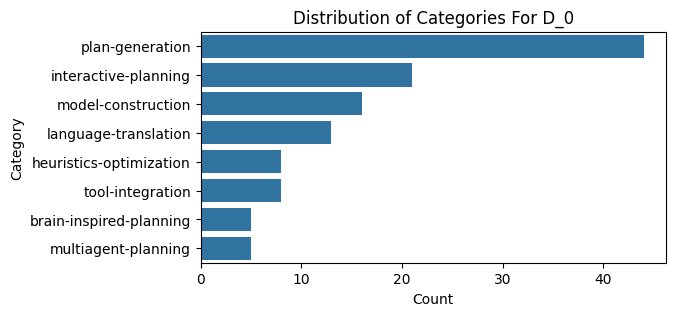

In [ ]:
generate_distribution(df_existing, "category", "Distribution of Categories For D_0")

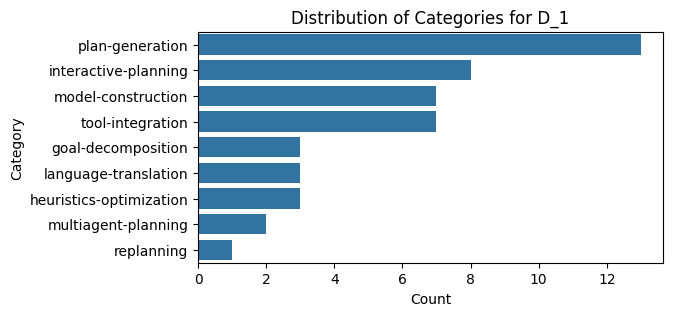

In [ ]:
generate_distribution(df_new, "Categories", "Distribution of Categories for D_1")

<br>


## Create Features


In [ ]:
# Create features
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_old = vectorizer.fit_transform(df_existing["text"])
X_new = vectorizer.transform(df_new["text"])

In [22]:
# Convert sparse matrix to array for iterative stratification
X_old_array = X_old.toarray()

In [ ]:
# Initialize label encoder
le = LabelEncoder()
y_old = le.fit_transform(df_existing["category"])

In [24]:
# Transform new data categories, handling unseen labels
def transform_labels(labels, le):
    new_labels = []
    for label in labels:
        if label in le.classes_:
            new_labels.append(le.transform([label])[0])
        else:
            new_labels.append(-1)  # Use -1 for unseen categories
    return np.array(new_labels)

In [ ]:
y_new = transform_labels(df_new["Categories"], le)

In [26]:
# Replace MultilabelStratifiedShuffleSplit with StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(X_old_array, y_old):
    X_train = X_old[train_idx]
    X_test = X_old[test_idx]
    y_train = y_old[train_idx]
    y_test = y_old[test_idx]

In [27]:
# Print some information about the split
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (96, 2974)
Test set shape: (24, 2974)


## Train, Evaluate, and Test Model


In [ ]:
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
    When seed is a false-y value or not supplied, disables deterministic mode."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed = 472
set_seed(seed)

In [ ]:
class PaperDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
        }

In [ ]:
class TransformerClassifier:
    def __init__(
        self,
        model_name,
        num_labels,
        device="cuda" if torch.cuda.is_available() else "cpu",
    ):
        self.device = device
        self.model_name = model_name
        self.num_labels = num_labels

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.base_model = AutoModel.from_pretrained(model_name).to(device)

        # Freeze the transformer parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Modified classifier for single-label classification
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.base_model.config.hidden_size, num_labels),
            torch.nn.LogSoftmax(dim=1),
        ).to(device)

    def get_embeddings(self, texts, batch_size=8):
        dataset = PaperDataset(texts, self.tokenizer)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        all_embeddings = []

        self.base_model.eval()
        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Getting embeddings"):
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)

                outputs = self.base_model(
                    input_ids=input_ids, attention_mask=attention_mask
                )

                # Use [CLS] token embedding
                embeddings = outputs.last_hidden_state[:, 0, :]
                all_embeddings.append(embeddings.cpu())

        return torch.cat(all_embeddings, dim=0)

    def predict(self, texts, batch_size=8):
        embeddings = self.get_embeddings(texts)
        with torch.no_grad():
            logits = self.classifier(embeddings.to(self.device))
            predictions = torch.argmax(logits, dim=1)
        return predictions.cpu().numpy()

In [ ]:
def evaluate_models(X_test, y_test, df_new, le):
    model_configs = {
        "BERT": "bert-base-uncased",
        "SciBERT": "allenai/scibert_scivocab_uncased",
    }

    results = {}

    if scipy.sparse.issparse(X_test):
        X_test = X_test.toarray()

    for model_name, model_path in model_configs.items():
        print(f"\nEvaluating {model_name}...")

        # Initialize classifier
        classifier = TransformerClassifier(model_path, num_labels=len(le.classes_))

        # Get predictions for test set
        y_pred_test = classifier.predict(X_test)

        # Get predictions for new data
        y_pred_new = classifier.predict(df_new["text"])

        # Convert numeric predictions back to category labels
        y_pred_test_labels = le.inverse_transform(y_pred_test)
        y_pred_new_labels = le.inverse_transform(y_pred_new)

        results[model_name] = {
            "test_report": classification_report(
                le.inverse_transform(y_test), y_pred_test_labels, zero_division=0
            ),
            "predictions": y_pred_new_labels,
        }

        # Store predictions in dataframe
        df_new[f"{model_name}_predicted"] = y_pred_new_labels

    return results

In [37]:
# Now evaluate the models using the test set we created earlier
results = evaluate_models(X_test, y_test, df_new, le)


Evaluating BERT...


/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Getting embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.40s/it]



Evaluating SciBERT...


/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Getting embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.51s/it]


In [ ]:
def get_detailed_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro"
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )

    # Get the standard classification report
    class_report = classification_report(y_true, y_pred, zero_division=0)

    # Add detailed metrics
    detailed_metrics = f"""
Classification Report:
{class_report}

Additional Metrics:
Accuracy: {accuracy:.4f}

Micro-averaged metrics:
Precision: {precision_micro:.4f}
Recall: {recall_micro:.4f}
F1-score: {f1_micro:.4f}

Macro-averaged metrics:
Precision: {precision_macro:.4f}
Recall: {recall_macro:.4f}
F1-score: {f1_macro:.4f}
"""
    return detailed_metrics

In [ ]:
for model_name, model_data in results.items():
    print(f"\nResults for {model_name} on test set:")
    print(
        get_detailed_metrics(
            le.inverse_transform(y_test), model_data["predictions"][: len(y_test)]
        )
    )

    print(f"\nPerformance on new data for {model_name}:")
    # Filter out rows where y_new is -1 (unseen categories)
    mask = y_new != -1
    if mask.any():
        print(
            get_detailed_metrics(
                le.inverse_transform(y_new[mask]), model_data["predictions"][mask]
            )
        )
    else:
        print("No matching categories found in new data")

    print("-" * 30)


Results for BERT on test set:

Classification Report:
                         precision    recall  f1-score   support

brain-inspired-planning       0.00      0.00      0.00         1
heuristics-optimization       0.00      0.00      0.00         1
   interactive-planning       0.00      0.00      0.00         4
   language-translation       0.13      0.67      0.22         3
     model-construction       0.11      0.33      0.17         3
    multiagent-planning       0.00      0.00      0.00         1
        plan-generation       0.00      0.00      0.00         9
       tool-integration       0.00      0.00      0.00         2

               accuracy                           0.12        24
              macro avg       0.03      0.12      0.05        24
           weighted avg       0.03      0.12      0.05        24


Additional Metrics:
Accuracy: 0.1250

Micro-averaged metrics:
Precision: 0.1250
Recall: 0.1250
F1-score: 0.1250

Macro-averaged metrics:
Precision: 0.0306
Recall

/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nitingupta/miniconda3/envs/lit-cat/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [40]:
df_new.columns

Index(['Title', 'Authors', 'Published Date', 'Abstract', 'URL', 'Categories',
       'Comments', 'text', 'BERT_predicted', 'SciBERT_predicted'],
      dtype='object')

In [ ]:
# Save results to the same CSV
df_new.to_csv("../outputs/tf_single_final.csv", index=False)